In [199]:
import sys, os, re, glob
import numpy as np

import matplotlib
#matplotlib.use('Agg')

import matplotlib.pyplot as plt
import scipy.ndimage as nd
import skimage.morphology as morpho

from deeplate.MMdata import MMData 

In [200]:
folder = '/scicore/home/nimwegen/urchuegu/projects/prj_noise_across_conditions_main/cell_size/data/20170126/201710126_lowerbound'

In [201]:
MMobj = MMData(folder = folder)

In [202]:
print(MMobj.channels)

['GFP', 'DIA (GFP)']


In [203]:
##second part of training generation with sorted out segmentations
path_to_save = '/scicore/home/nimwegen/witzg/DeepLearningData/Learn20170126_watershed/good/'
path_to_save = os.path.normpath(path_to_save)

In [204]:
#based on the above outpout set fluo and bright field channels
fluo_ch = 0
bf_ch = 1

In [205]:
good_seg = glob.glob(path_to_save+'/segplot*.png')

In [206]:
good_seg

['/scicore/home/nimwegen/witzg/DeepLearningData/Learn20170126_watershed/good/segplot108.png',
 '/scicore/home/nimwegen/witzg/DeepLearningData/Learn20170126_watershed/good/segplot43.png',
 '/scicore/home/nimwegen/witzg/DeepLearningData/Learn20170126_watershed/good/segplot137.png',
 '/scicore/home/nimwegen/witzg/DeepLearningData/Learn20170126_watershed/good/segplot166.png',
 '/scicore/home/nimwegen/witzg/DeepLearningData/Learn20170126_watershed/good/segplot109.png',
 '/scicore/home/nimwegen/witzg/DeepLearningData/Learn20170126_watershed/good/segplot61.png',
 '/scicore/home/nimwegen/witzg/DeepLearningData/Learn20170126_watershed/good/segplot142.png',
 '/scicore/home/nimwegen/witzg/DeepLearningData/Learn20170126_watershed/good/segplot116.png',
 '/scicore/home/nimwegen/witzg/DeepLearningData/Learn20170126_watershed/good/segplot42.png',
 '/scicore/home/nimwegen/witzg/DeepLearningData/Learn20170126_watershed/good/segplot62.png',
 '/scicore/home/nimwegen/witzg/DeepLearningData/Learn20170126_wa

In [207]:
pos_indices = [int(re.findall('.*?(\d*).png',x)[0]) for x in good_seg]
numpos = len(pos_indices)

In [208]:
mid_plane = int((MMobj.num_planes[bf_ch]-1)/2)

In [209]:
all_masks = np.empty((MMobj.height, MMobj.width,numpos))
all_weights = np.empty((MMobj.height,MMobj.width,numpos))
all_planes = np.empty((MMobj.height,MMobj.width,3, numpos)) 

In [216]:
all_masks = np.empty((MMobj.height, MMobj.width,numpos))
all_weights = np.empty((MMobj.height,MMobj.width,numpos))
for i in range(numpos):
    all_masks[:,:,i] = np.load(path_to_save+'/mask_'+str(pos_indices[i])+'.npy')
cellfrac = np.sum(all_masks)/all_masks.ravel().shape[0]
factor = (1-cellfrac)/cellfrac
print(factor)

10.017075287376533
61.08260140566294


In [272]:
path_to_save_crops ='/scicore/home/nimwegen/witzg/DeepLearningData/Learn20170126_watershed/crops/'
if not os.path.exists(path_to_save_crops):
    os.makedirs(path_to_save_crops)

unitsize = 128
numsplits = int(all_masks.shape[0]/unitsize)

channels = 10#1
image_rows = unitsize#128
image_cols = unitsize#128

all_planes = np.empty((MMobj.height,MMobj.width,21))
glob_counter = 0
for i in range(numpos):
    print(i)
    mask = np.load(path_to_save+'/mask_'+str(pos_indices[i])+'.npy')
    weight = np.load(path_to_save+'/weight_'+str(pos_indices[i])+'.npy').astype(int)
    
    weight = morpho.binary_dilation(weight,selem = morpho.disk(radius=1)).astype(int)
    mask[weight==1]=0
    
    weight[weight==1] = 200
    weight[weight==0] = 1
    weight[mask==1] = int(factor)

    for j in range(21):
        plane = mid_plane-10+j
        all_planes[:,:,j] = MMobj.get_image_fast(frame=0,channel=bf_ch,plane=plane,position=pos_indices[i], compress = 1)
    
    for m in range(numsplits):
        for n in range(numsplits):
                init_rand = np.random.randint(0,21-10+1)
                img = all_planes[m*unitsize:(m+1)*unitsize,n*unitsize:(n+1)*unitsize,init_rand:init_rand+10]
    
                for q in range(img.shape[2]):
                    img[:,:,q] = nd.gaussian_filter(img[:,:,q],3)

                '''meanstack = np.mean(img,axis =2)
                for q in range(img.shape[2]):
                    img[:,:,q] = img[:,:,q]-meanstack'''

                img = img-np.mean(img)
                img = img/np.std(img)

                img_mask = 255*mask[m*image_rows:(m+1)*image_rows,n*image_cols:(n+1)*image_cols]
                img_weight = weight[m*image_rows:(m+1)*image_rows,n*image_cols:(n+1)*image_cols]
                
                np.save(path_to_save_crops+'/img_'+str(glob_counter)+'.npy', img)
                np.save(path_to_save_crops+'/img_mask_'+str(glob_counter)+'.npy', img_mask)
                np.save(path_to_save_crops+'/img_weight_'+str(glob_counter)+'.npy', img_weight)
                glob_counter+=1


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35


In [273]:
glob_counter/32

288.0

In [274]:
shuffle = np.random.choice(glob_counter, glob_counter, replace=False)

In [275]:
path_to_save_batches ='/scicore/home/nimwegen/witzg/DeepLearningData/Learn20170126_watershed/batches_thin/'
if not os.path.exists(path_to_save_batches):
    os.makedirs(path_to_save_batches)

In [276]:
batchsize = 32

In [277]:
numbatches = int(np.round(glob_counter/batchsize))

In [278]:
numtrain = int(numbatches*0.8)
numvalid = numbatches-numtrain

In [279]:
'''numbatches = 10
numtrain = 8
numvalid = 2'''
channels = 10
for b in range(numbatches):
    imgs = np.ndarray((batchsize, unitsize, unitsize,channels), dtype=np.float64)
    imgs_mask = np.ndarray((batchsize, unitsize, unitsize), dtype=np.uint8)
    imgs_weight = np.ndarray((batchsize, unitsize, unitsize), dtype=np.uint8)
    
    cur_shuffle = shuffle[batchsize*b:batchsize*(b+1)]
    for c in range(batchsize):
        imgs[c,:,:,:] = np.load(path_to_save_crops+'/img_'+str(cur_shuffle[c])+'.npy')
        imgs_mask[c,:,:] = np.load(path_to_save_crops+'/img_mask_'+str(cur_shuffle[c])+'.npy')
        imgs_weight[c,:,:] = np.load(path_to_save_crops+'/img_weight_'+str(cur_shuffle[c])+'.npy')
    if b<numtrain:
        np.save(path_to_save_batches+'/imgs_train_'+str(b)+'.npy', imgs)
        np.save(path_to_save_batches+'/imgs_mask_train_'+str(b)+'.npy', imgs_mask.reshape((batchsize,unitsize*unitsize)))
        np.save(path_to_save_batches+'/imgs_weight_train_'+str(b)+'.npy', imgs_weight.reshape((batchsize,unitsize*unitsize)))
    else:
        np.save(path_to_save_batches+'/imgs_valid_'+str(b-numtrain)+'.npy', imgs)
        np.save(path_to_save_batches+'/imgs_mask_valid_'+str(b-numtrain)+'.npy', imgs_mask.reshape((batchsize,unitsize*unitsize)))
        np.save(path_to_save_batches+'/imgs_weight_valid_'+str(b-numtrain)+'.npy', imgs_weight.reshape((batchsize,unitsize*unitsize)))



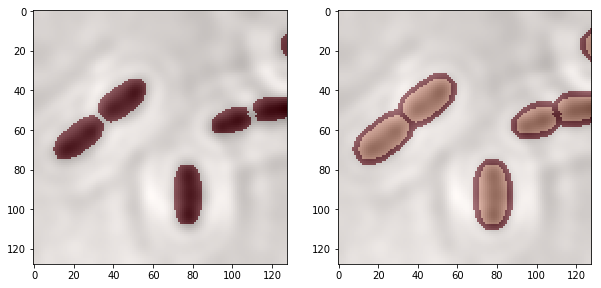

In [282]:
#check individul examples of training set
fig, ax = plt.subplots(figsize=(10,10))
plt.subplot(1,2,1)
id = 31
plt.imshow(imgs[id,:,:,9],cmap = 'gray')
plt.imshow(np.reshape(imgs_mask[id,:],(image_rows,image_cols)),alpha = 0.5, cmap = 'Reds')
plt.subplot(1,2,2)
plt.imshow(imgs[id,:,:,9],cmap = 'gray')
plt.imshow(np.reshape(imgs_weight[id,:],(image_rows,image_cols)),alpha = 0.5, cmap = 'Reds')
plt.show()

In [198]:
np.unique(np.reshape(imgs_weight[id,:],(image_rows,image_cols)))

array([  1,  10, 200], dtype=uint8)